In [1]:
import sys; sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)

font = {'family':'serif'} 
plt.rc('font',**font)
from experiments import initial_mean_experiment, three_centered_dists_experiment

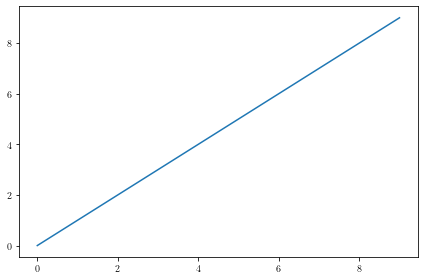

In [2]:
plt.plot(range(10))

## Three symmetric distributions centered at 0.5

1. Uniform
1. Normal
1. Beta with $\alpha=\beta=2$ (see examples below)

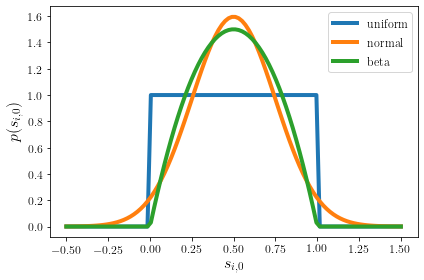

In [3]:
from scipy.stats import beta, uniform, norm

x = np.linspace(-0.5, 1.5, num=100)
unif = uniform.pdf(x)
norm = norm.pdf(x, loc=0.5, scale=0.25)
beta = beta.pdf(x, a=2, b=2, loc=0, scale=1)

plt.plot(x, unif, label='uniform', lw=4)
plt.plot(x, norm, label='normal', lw=4)
plt.plot(x, beta, label='beta', lw=4)

plt.xlabel(r'$s_{i,0}$', size=16)
plt.ylabel(r'$p(s_{i,0})$', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.legend(prop={'size': 12})

plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/distros.pdf')

### Uniform distribution

In [4]:
uniform_result = three_centered_dists_experiment(n_trials=100)

print(uniform_result['experiment_result'][0].shift)
print(np.mean([el.shift for el in uniform_result['experiment_result']]))
print(np.std([el.shift for el in uniform_result['experiment_result']]))

0.19999999999999996
0.3488000000000001
0.28239433422078425


### Normal distribution

In [5]:
normal_result = three_centered_dists_experiment(dist='normal', n_trials=100)

# print(normal_result['experiment_result'][0].shift)
print(np.mean([el.shift for el in normal_result['experiment_result']]))
print(np.std([el.shift for el in normal_result['experiment_result']]))

0.3956
0.2908687676599191


### Beta distribution $\alpha=\beta=2$

In [6]:
beta_result = three_centered_dists_experiment(dist='beta', n_trials=100)

print(beta_result['experiment_result'][0].shift)
print(np.mean([el.shift for el in beta_result['experiment_result']]))
print(np.std([el.shift for el in beta_result['experiment_result']]))

0.43999999999999995
0.2416
0.1464152997469868


I want to see the distributions as well as the means and standard deviations, so I will plot using seaborn strip plot to complement a table I made in the paper with $\langle \delta \rangle$ as a function of distro.

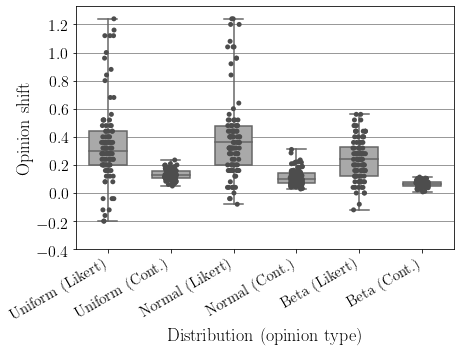

In [7]:
# df = pd.DataFrame(columns=['Distribution', 'Shift', 'CShift'])
df = pd.read_csv('backup_distro_experiment.csv')
# Initialize dataframe by adding uniform distribution data first
df = pd.DataFrame(
    {
        'Distribution': ['Uniform (Likert)']* 100 + 
                        ['Uniform (Cont.)'] * 100  +
                        ['Normal (Likert)']* 100 + 
                        ['Normal (Cont.)'] * 100 +
                        ['Beta (Likert)']* 100 + 
                        ['Beta (Cont.)'] * 100  
                        ,  
        'Shift':
            [uniform_result['experiment_result'][idx].shift
                      for idx in range(100)] + 
            [uniform_result['experiment_result'][idx].contin_shift
                      for idx in range(100)] +
            [normal_result['experiment_result'][idx].shift
                      for idx in range(100)] + 
            [normal_result['experiment_result'][idx].contin_shift
                      for idx in range(100)] +
            [beta_result['experiment_result'][idx].shift
                      for idx in range(100)] + 
            [beta_result['experiment_result'][idx].contin_shift
                      for idx in range(100)]
    }
)

# df.to_csv('backup_distro_experiment.csv')

plt.figure(figsize=(6.5, 5))
ax = sns.boxplot(x="Distribution", y="Shift",  data=df, width=0.6,
                 whis=np.inf, color='darkgrey')
ax = sns.stripplot(x="Distribution", y="Shift", data=df, jitter=True, color=".3")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')

plt.xlabel('Distribution (opinion type)', size=18)
plt.ylabel('Opinion shift', size=18)
plt.xticks(size=15, rotation=30, ha='right', family='serif')
plt.yticks(np.arange(-0.4, 1.4, 0.2), size=16)

plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/shiftVsDistro.pdf')

#### Experiment with same standard deviation for Normal, evaluate different init norms

I'll do a similar experiment as before with $\mu_0 \in \{0.2, 0.3, \ldots, 0.8\}$ in order to evaluate how that changes things. Hope to get the sort of plot in Figure 1 of Myers (1982) where shift increases as initial mean increases in extremity. However, we may see the same sort of binning noise found in the sweeps above for a smaller standard deviation. Standard deviation in the above experiments over distribution used extremity_factor * 0.25 as the mean.

In [8]:
extremity_factor = 3.5
stddev = extremity_factor * 0.25
means = extremity_factor * np.arange(start=.2, stop=.81, step=.1)
print(means)
norm_over_means = initial_mean_experiment(
    means=means, stddev=stddev, dist='normal', n_trials=100
)

[0.7  1.05 1.4  1.75 2.1  2.45 2.8 ]
Bound = 0.7000000000000001
Running trials for 0.700
Running trials for 1.050
Running trials for 1.400
Running trials for 1.750
Running trials for 2.100
Running trials for 2.450
Running trials for 2.800


In [13]:
means = list(norm_over_means.keys())
n_means = len(means)
shift_mean_at_dist_mean = np.zeros((n_means,), dtype=float)
shift_std_at_dist_mean = np.zeros((n_means,), dtype=float)


df = pd.DataFrame(columns=['InitialMean', 'Shift'])
for idx in range(n_means):
    

    current_mean = means[idx]
    results_for_mean = list(norm_over_means.values())[idx]['experiment_result']

    shifts = [el.shift for el in results_for_mean]
#     print(shifts)

    shift_mean_at_dist_mean[idx] = np.mean(shifts)
    shift_std_at_dist_mean[idx] = np.std(shifts)
    
    df_part = pd.DataFrame({
        'InitialMean': [current_mean] * len(shifts),
        'Shift': shifts
    })

    df = df.append(df_part)
    

In [14]:
plt.errorbar(x=means, y=shift_mean_at_dist_mean, yerr=2*shift_std_at_dist_mean)
plt.xlabel(r'$\mu_0$', size=16)
plt.xticks(size=12, rotation=60)
plt.ylabel(r'$\delta$', size=16)
plt.yticks(size=12)
plt.grid(axis='y')
plt.title('n_iter=100, n_trials=100')

Text(0.5, 1.0, 'n_iter=100, n_trials=100')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x119830e60> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'n_iter=100, n_trials=100'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/mt/.matplotlib/tex.cache/e475b3e5bb3d3d6123aca0f79c887371.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./e475b3e5bb3d3d6123aca0f79c887371.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{12.000000}{15.000000}{\rmfamily n_
                                                 iter=100, n_trials=100}
No pages of output.
Transcript written on e475b3e5bb3d3d6123aca0f79c887371.log.




RuntimeError: latex was not able to process the following string:
b'n_iter=100, n_trials=100'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/mt/.matplotlib/tex.cache/e475b3e5bb3d3d6123aca0f79c887371.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./e475b3e5bb3d3d6123aca0f79c887371.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 \fontsize{12.000000}{15.000000}{\rmfamily n_
                                                 iter=100, n_trials=100}
No pages of output.
Transcript written on e475b3e5bb3d3d6123aca0f79c887371.log.




<Figure size 432x288 with 1 Axes>

In [10]:
df.head()

,InitialMean,Shift
0,0.700,0.00
1,0.700,0.12
2,0.700,0.40
3,0.700,0.40
4,0.700,0.36


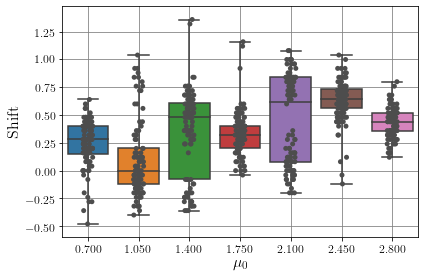

In [11]:
ax = sns.boxplot(x="InitialMean", y="Shift", data=df, whis=np.inf)
# ax = sns.boxplot(x="Distribution", y="Shift", data=df)
ax = sns.stripplot(x="InitialMean", y="Shift", data=df, jitter=True, color=".3")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
ax.xaxis.grid(color='gray')
plt.xlabel('$\mu_0$', size=16)
plt.ylabel('Shift', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/ShiftVsDist.pdf')

One more experiment with this simple normally-distributed case: bound values less than zero to be zero. Introducing a `bound_zero` kwarg.

In [15]:
extremity_factor = 3.5
stddev = extremity_factor * 0.25
means = extremity_factor * np.arange(start=.2, stop=.81, step=.1)

norm_over_means = initial_mean_experiment(
    means=means, stddev=stddev, dist='normal', n_trials=100, bound_zero=True
)

Bound = 0.7000000000000001
Running trials for 0.700
Running trials for 1.050
Running trials for 1.400
Running trials for 1.750
Running trials for 2.100
Running trials for 2.450
Running trials for 2.800


In [ ]:
means = list(norm_over_means.keys())
n_means = len(means)

shift_mean_at_dist_mean = np.zeros((n_means,), dtype=float)
shift_std_at_dist_mean = np.zeros((n_means,), dtype=float)
cshift_mean_at_dist_mean = np.zeros((n_means,), dtype=float)
cshift_std_at_dist_mean = np.zeros((n_means,), dtype=float)

df = pd.DataFrame(columns=['InitialMean', 'Shift', 'CShift'])
for idx in range(n_means):
    
    current_mean = means[idx]
    results_for_mean = list(norm_over_means.values())[idx]['experiment_result']

    shifts = [el.shift for el in results_for_mean]
    contin_shifts = [el.contin_shift for el in results_for_mean]
#     print(shifts)

    shift_mean_at_dist_mean[idx] = np.mean(shifts)
    shift_std_at_dist_mean[idx] = np.std(shifts)
    cshift_mean_at_dist_mean[idx] = np.mean(contin_shifts)
    cshift_std_at_dist_mean[idx] = np.std(contin_shifts)
    
    df_part = pd.DataFrame({
        'InitialMean': [current_mean] * len(shifts),
        'Shift': shifts,
        'CShift': contin_shifts
    })

    df = df.append(df_part)
    

plt.figure()

# ax = sns.boxplot(x="Distribution", y="Shift", data=df)

xlabel = 'Initial mean opinion'
ylabel = 'Opinion shift'

x = sns.boxplot(x="InitialMean", y="Shift", data=df, color='lightgray', 
                 width=0.6, whis=np.inf)

ax = sns.stripplot(x="InitialMean", y="Shift", data=df, jitter=True, color=".3")
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
# ax.xaxis.grid(color='gray')


plt.xlabel(xlabel, size=16)
plt.ylabel(ylabel, size=16)
plt.xticks(size=14)
plt.yticks(np.arange(-0.4, 1.4, 0.2), size=14)
plt.title('7-point Likert', size=16)
plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/7pointLikertBoxplot.pdf')

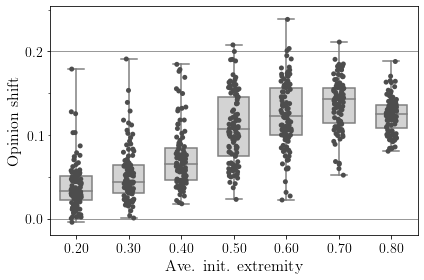

In [18]:
plt.figure()
ax = sns.boxplot(x="InitialMean", y="CShift", data=df, color='lightgray', 
                 width=0.6, whis=np.inf)
# ax = sns.boxplot(x="Distribution", y="Shift", data=df)
ax = sns.stripplot(x="InitialMean", y="CShift", data=df, jitter=True, color=".3")

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray')
# ax.xaxis.grid(color='gray')
plt.xlabel('Ave. init. extremity', size=16)
plt.ylabel('Opinion shift', size=16)
plt.xticks(size=14)

plt.yticks([0.0, 0.2], size=14)
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_yticklabels(['', '0.1', '', ''], minor=True, size=14)
ax.set_xticklabels([f'{(val/3.5):.2f}' for val in np.arange(0.7, 2.81, 0.350)])
# plt.title('Continuous', size=16)
plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/ContinuousBoxplot.pdf')

In [ ]:
# Begin plotting four cases.
xlabel = r'Initial mean, $\mu_0$'
ylabel = r'Shift, $\delta$'
plt.errorbar(x=means, y=shift_mean_at_dist_mean, yerr=2*shift_std_at_dist_mean)
plt.xlabel(xlabel, size=16)
plt.xticks(size=12, rotation=60)
plt.ylabel(ylabel, size=16)
plt.yticks(size=12)
plt.grid(axis='y')
plt.title('7-point Likert', size=16)
plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/7pointLikertSeries.pdf')

plt.figure()
plt.errorbar(x=means, y=cshift_mean_at_dist_mean, yerr=2*cshift_std_at_dist_mean)
plt.xlabel(xlabel, size=16)
plt.xticks(size=12, rotation=60)
plt.ylabel(ylabel, size=16)
plt.yticks(size=12)
plt.grid(axis='y')
plt.title('Continuous', size=16)
plt.savefig('/Users/mt/workspace/papers/cogsci2020/Figures/ContinuousSeries.pdf')
